# Load Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from torchvision import transforms
import torch

from torch.optim import lr_scheduler
import torch.optim as optim

from trainer import fit

cuda = torch.cuda.is_available()

%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from utils import seed_torch, load_training, plot_embeddings, extract_embeddings, cosine_similarity


# Transform

In [ ]:
transform_RGB = transforms.Compose([transforms.Resize([256, 256]),
                                   transforms.ToTensor()])

transform = transform_RGB

In [4]:
train_loader, train_data, train_classtoid, train_cl = load_training("/workspace/data/FSL/data1/", "train", transform, 128)
test_loader, test_data, test_classtoid, test_cl = load_training("/workspace/data/FSL/data1/", "test", transform, 128)
#flobot_test_loader, flobot_test_data, flobot_test_classtoid, flobot_test_cl = load_training("/workspace/data/FSL/data1/", "test_flobot", transform, 4)
sup1_loader, sup1_data, sup1_classtoid, sup1_cl = load_training("/workspace/data/FSL/data1/", "valid1", transform, 4)
#sup2_loader, sup2_data, sup2_classtoid, sup2_cl = load_training("/workspace/data/FSL/data1/", "valid2", transform, 4)
#sup3_loader, sup3_data, sup3_classtoid, sup3_cl = load_training("/workspace/data/FSL/data1/", "valid3", transform, 4)
#sup4_loader, sup4_data, sup4_classtoid, sup4_cl = load_training("/workspace/data/FSL/data1/", "valid4", transform, 4)

# Prepare CSV for Loader

In [7]:
df_trainlist = pd.DataFrame(train_data.imgs, columns = ['path', 'label'])
df_testlist = pd.DataFrame(test_data.imgs, columns = ['path', 'label'])
df_flobot_testlist = pd.DataFrame(flobot_test_data.imgs, columns = ['path', 'label'])
df_sup1list = pd.DataFrame(sup1_data.imgs, columns = ['path', 'label'])
df_sup2list = pd.DataFrame(sup2_data.imgs, columns = ['path', 'label'])
df_sup3list = pd.DataFrame(sup3_data.imgs, columns = ['path', 'label'])
df_sup4list = pd.DataFrame(sup4_data.imgs, columns = ['path', 'label'])


In [8]:
df_trainlist.to_csv("/workspace/data/FSL/siamese-triplet/csv/train_cust.csv", header= False)
df_testlist.to_csv("/workspace/data/FSL/siamese-triplet/csv/test_cust.csv", header= False)
df_flobot_testlist.to_csv("/workspace/data/FSL/siamese-triplet/csv/flobot_test.csv", header= False)
df_sup1list.to_csv("/workspace/data/FSL/siamese-triplet/csv/sup1_cust.csv", header= False)
df_sup2list.to_csv("/workspace/data/FSL/siamese-triplet/csv/sup2_cust.csv", header= False)
df_sup3list.to_csv("/workspace/data/FSL/siamese-triplet/csv/sup3_cust.csv", header= False)
df_sup4list.to_csv("/workspace/data/FSL/siamese-triplet/csv/sup4_cust.csv", header= False)

# Experiments
For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [5]:
# Set up data loaders
from datasets import CUHK_train_RGB, CUHK_test_RGB

triplet_train_dataset = CUHK_train_RGB("/workspace/data/FSL/siamese-triplet/csv/train_cust.csv", train_data) # Returns triplets of images
triplet_test_dataset = CUHK_test_RGB("/workspace/data/FSL/siamese-triplet/csv/sup1_cust.csv", sup1_data)




batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=False,worker_init_fn=seed_torch, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_torch, **kwargs)

# Set up the network and training parameters
from networks import TripletNet, EmbeddingNet128_RGB
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet128_RGB()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3


optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)


#cheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 7
log_interval = 100

printing train data length CUHK
8970


# Fit on training dataset

In [6]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)


/workspace/data/FSL/.venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/8970 (0%)]	Loss: 1.000008
Epoch: 1/7. Train set: Average loss: 0.7075
Epoch: 1/7. Validation set: Average loss: 0.9655
Train: [0/8970 (0%)]	Loss: 1.471025
Epoch: 2/7. Train set: Average loss: 0.5186
Epoch: 2/7. Validation set: Average loss: 1.1515
Train: [0/8970 (0%)]	Loss: 1.015669
Epoch: 3/7. Train set: Average loss: 0.4549
Epoch: 3/7. Validation set: Average loss: 6.0526
Train: [0/8970 (0%)]	Loss: 3.870515
Epoch: 4/7. Train set: Average loss: 0.4293
Epoch: 4/7. Validation set: Average loss: 0.8984
Train: [0/8970 (0%)]	Loss: 1.503271
Epoch: 5/7. Train set: Average loss: 0.5070
Epoch: 5/7. Validation set: Average loss: 2.2040
Train: [0/8970 (0%)]	Loss: 1.416690
Epoch: 6/7. Train set: Average loss: 0.3570
Epoch: 6/7. Validation set: Average loss: 1.6005
Train: [0/8970 (0%)]	Loss: 1.329407
Epoch: 7/7. Train set: Average loss: 0.4201
Epoch: 7/7. Validation set: Average loss: 2.3026


# Generatre embeddings from trained model

In [7]:
emb_len = 128
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model, emb_len)
sup_embeddings_tl, sup_labels_tl = extract_embeddings(sup1_loader, model, emb_len)
test_embeddings_tl, test_labels_tl = extract_embeddings(test_loader, model, emb_len)

In [8]:
test_embeddings_tl.shape

(311, 128)

# Generate Results

In [9]:
pred = []
pred_ind = []
for i in range(len(test_embeddings_tl)):
    score_list = []
    for j in range(len(sup_embeddings_tl)):
        score = cosine_similarity(test_embeddings_tl[i], sup_embeddings_tl[j])
        score_list.append(score)
    max_ind = score_list.index(max(score_list)) 
    pred_ind.append(max_ind)
    pred.append(sup_labels_tl[max_ind])
    

In [10]:
train_pred = []
train_pred_ind = []
for i in range(len(train_embeddings_tl)):
    score_list = []
    for j in range(len(sup_embeddings_tl)):
        score = cosine_similarity(train_embeddings_tl[i], sup_embeddings_tl[j])
        score_list.append(score)
    max_ind = score_list.index(max(score_list)) 
    train_pred_ind.append(max_ind)
    train_pred.append(sup_labels_tl[max_ind])

In [11]:
print("Accuracy: ", accuracy_score(test_labels_tl,pred))
print("f1 Score: ", f1_score(test_labels_tl,pred))
print("Confusion matrix: ", confusion_matrix(test_labels_tl,pred))
print(classification_report(test_labels_tl, pred, labels= [0, 1]))


Accuracy:  0.6334405144694534
f1 Score:  0.6369426751592356
Confusion matrix:  [[ 97  20]
 [ 94 100]]
              precision    recall  f1-score   support

           0       0.51      0.83      0.63       117
           1       0.83      0.52      0.64       194

    accuracy                           0.63       311
   macro avg       0.67      0.67      0.63       311
weighted avg       0.71      0.63      0.63       311



In [12]:
print("Train Accuracy: ", accuracy_score(train_labels_tl,train_pred))
print("Train f1 Score: ", f1_score(train_labels_tl,train_pred))
print("Train Confusion matrix: ", confusion_matrix(train_labels_tl,train_pred))
print(classification_report(train_labels_tl,train_pred, labels= [0, 1]))

Train Accuracy:  0.4211817168338908
Train f1 Score:  0.1729850270786875
Train Confusion matrix:  [[3235 4013]
 [1179  543]]
              precision    recall  f1-score   support

           0       0.73      0.45      0.55      7248
           1       0.12      0.32      0.17      1722

    accuracy                           0.42      8970
   macro avg       0.43      0.38      0.36      8970
weighted avg       0.62      0.42      0.48      8970



# Plot embeddings

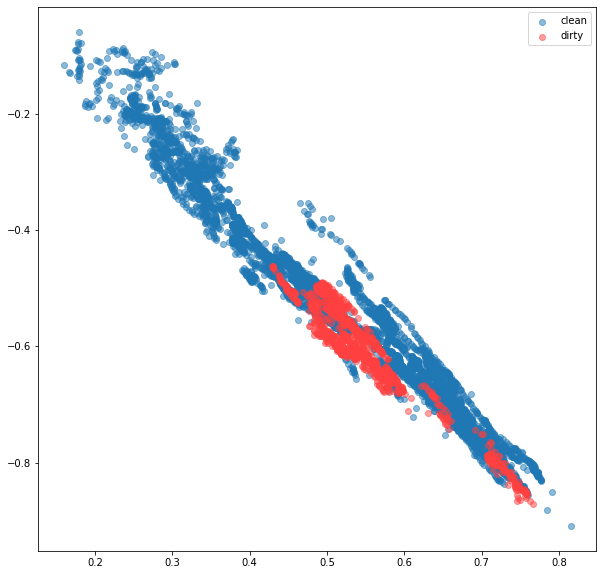

In [13]:
plot_embeddings(train_embeddings_tl, train_labels_tl, train_cl)

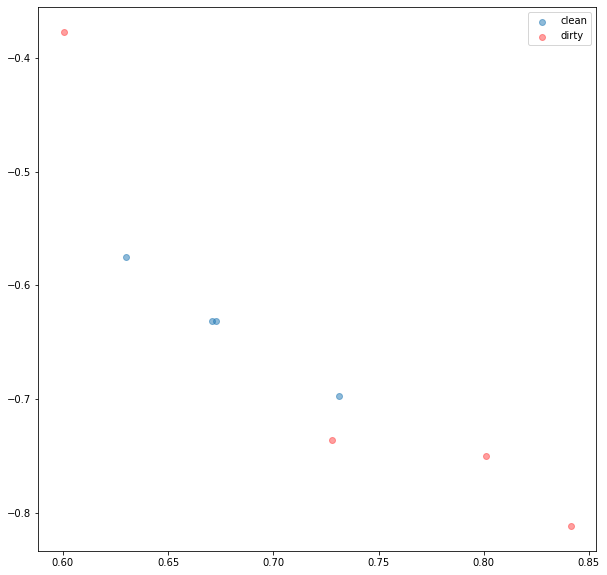

In [14]:
plot_embeddings(sup_embeddings_tl, sup_labels_tl, train_cl)

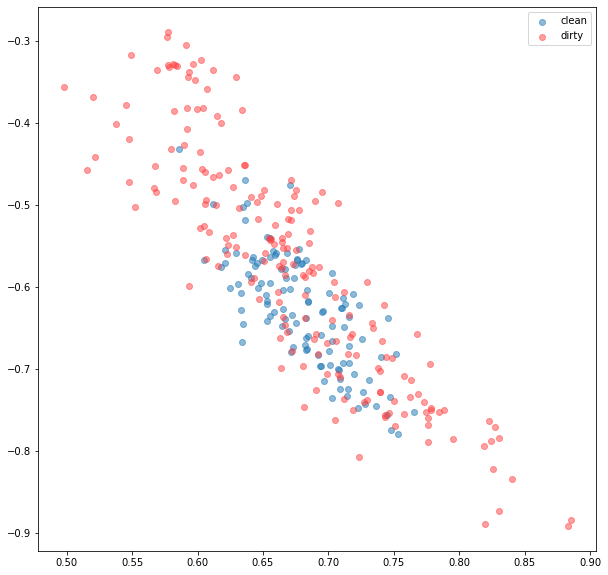

In [15]:
#test_embeddings_tl, test_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(test_embeddings_tl, test_labels_tl, train_cl)
